<a href="https://colab.research.google.com/github/Guille-Guille/pix2plot/blob/master/Relieves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este código está sacado del tutorial de DotCSV con alguna pequeña modificación ya que mis imagenes introducidas se reescalaran a 
1024 x 512

en vez de 256 x 256. Entre otros pequeños cambios, he aumentado el zoom que realiza el random_jitter para conseguir más imágenes de entrada.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Ruta raiz
PATH = "/content/drive/My Drive/IA/pix2pix"

# Ruta datos entrada
INPATH = PATH + "/foto"

# Ruta datos entrada
OUPATH = PATH + "/relieve"

# Ruta checkpoints
CKPATH = PATH + "/checkpoints2"

imgurls = !ls -1 "{INPATH}"

n = 70 # número de imágenes con los que trabajo
train_n = round(n * 0.80)

# listado randomizado

randurls = np.copy(imgurls)
np.random.shuffle(randurls)

# partición train/test

tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))

71 56 14


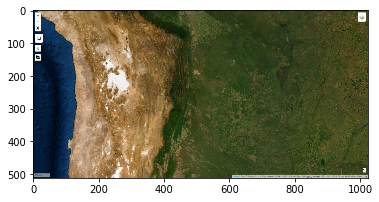

In [0]:
IMG_WIDTH = 1024
IMG_HEIGHT = 512

# Reescalar imágenes
def resize(inimg, tgimg, height, width):
  
  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])
  
  return inimg, tgimg

# normaliza al rango [ -1, +1] la imagen.
def normalize(inimg, tgimg):
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1
  
  return inimg, tgimg

# Aumentación de datos:random Crop + Flip
def random_jitter(inimg, tgimg):
  
  inimg, tgimg = resize(inimg, tgimg, 660, 1240)
  
  stacked_image = tf.stack([inimg, tgimg], axis = 0)
  cropped_image = tf.image.random_crop(stacked_image, size = [2,  IMG_HEIGHT, IMG_WIDTH, 3] )
  
  inimg, tgimg = cropped_image[0], cropped_image[1]
  
  if tf.random.uniform(()) > 0.5:
    
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)
    
  return inimg, tgimg

# Cargar imagenes
def load_image(filename, augment = True):
  
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUPATH + '/' + filename)), tf.float32)

  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)
  
  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)
    
  inimg, tgimg = normalize(inimg, tgimg)
  
  return inimg, tgimg


def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)


# la cuenta que hacemos aqui es porque imshow coge imagenes de [0,1] 


plt.imshow((load_test_image(randurls[5])[0]+1)/2)



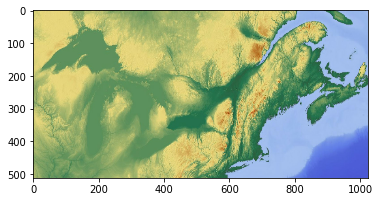

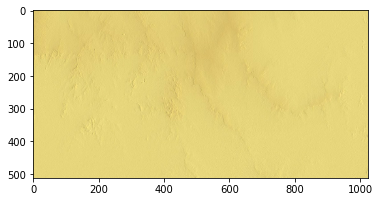

In [0]:
# crearemos los dataset para poder trabajar con tensorflow

train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

for inimg, tgimg in train_dataset.take(2):
    plt.imshow((tgimg[0,...]+1)/2)
    plt.show()

In [0]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm = True):
  
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02)
  # Capa convolucional.
  result.add(Conv2D(filters,
                    kernel_initializer = initializer,
                    kernel_size = 4,
                    strides = 2,
                    padding = "same",
                    use_bias = not apply_batchnorm))
  
  if apply_batchnorm:
    # Capa batchNorm
    result.add(BatchNormalization())
  
  # Capa de activación.
  result.add(LeakyReLU())
  
  return result

downsample(64)

In [0]:
def upsample(filters, apply_dropout = False):
  
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02)
  # Capa convolucional.
  result.add(Conv2DTranspose(filters,
                             kernel_initializer = initializer,
                             kernel_size = 4,
                             strides = 2,
                             padding = "same",
                             use_bias = False))
  

  # Capa batchNorm
  result.add(BatchNormalization())
  
  if apply_dropout:
    # Capa de Dropout
    result.add(Dropout(0.5))
    
  # Capa de activación.
  result.add(ReLU())
  
  return result

upsample(64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


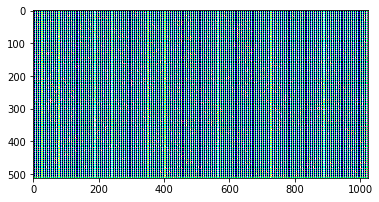

In [0]:
def Generator():
  
  inputs = tf.keras.layers.Input(shape = [None, None, 3])
  
  down_stack = [
      downsample(64, apply_batchnorm = False), # (bs, 512, 256, 64 )
      downsample(128),                        # (bs, 256, 128, 128 )
      downsample(256),                        # (bs, 128, 64, 256 )
      downsample(512),                        # (bs, 64, 32, 512 )
      downsample(512),                        # (bs, 32, 16, 512 )
      downsample(512),                        # (bs, 16, 8, 512 )
      downsample(512),                        # (bs, 8, 4, 512 )
      downsample(512),                        # (bs, 4, 2, 512 )
  ]
  
  up_stack = [
      upsample(512, apply_dropout = True),    # (bs, 8, 4, 1024 )
      upsample(512, apply_dropout = True),    # (bs, 16, 8, 1024 )
      upsample(512, apply_dropout = True),    # (bs, 32, 16, 1024 )
      upsample(512),                          # (bs, 64, 32, 1024 )
      upsample(256),                          # (bs, 128, 64, 512 )
      upsample(128),                          # (bs, 256, 128, 256 )
      upsample(64),                           # (bs, 512, 256, 128 )
  ]
  
  initializer = tf.random_normal_initializer(0, 0.02)

  last = Conv2DTranspose(filters= 3,
                         kernel_size = 4,
                         strides = 2,
                         padding = "same",
                         kernel_initializer = initializer,
                         activation = "tanh")
  
  x = inputs
  s = []
  
  concat = Concatenate()
  
  for down in down_stack:
    x = down(x)
    s.append(x)
    
  s = reversed(s[:-1])
  
  for up, sk in zip(up_stack, s):
    
    x = up(x)
    x = concat([x, sk])
    
  last = last(x)
  
  return Model(inputs = inputs, outputs = last)

generator = Generator()
gen_output = generator(((inimg+1)*255), training = False)
plt.imshow(gen_output[0,...])

TensorShape([1, 32, 64, 1])

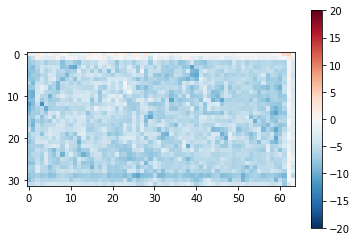

In [0]:
def Discriminator():
  
  ini = Input(shape = [None,None,3])
  gen = Input(shape = [None,None,3])
  
  con =concatenate([ini,gen])
  
  initializer = tf.random_normal_initializer(0,0.02)
  
  down1 = downsample(64, apply_batchnorm = False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)
  
  last = tf.keras.layers.Conv2D(filters = 1,
                                kernel_size = 4,
                                strides = 1,
                                kernel_initializer = initializer,
                                padding = "same")(down4)
  
  return tf.keras.Model(inputs = [ini,gen], outputs = last)

discriminator = Discriminator()

disc_out = discriminator([(inimg+1)*255, gen_output], training = False)
plt.imshow(disc_out[0,...,-1], vmin = -20, vmax = 20, cmap = 'RdBu_r')
plt.colorbar()
disc_out.shape

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  
  # Diferenciea entre los true por ser real y detectado por el discriminador
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  
  # Diferencia entre los false por ser generado y el detectado por el discriminador
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  
  total_disc_loss = real_loss + generated_loss
  
  return total_disc_loss

In [0]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  #mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  
  return total_gen_loss

In [0]:
import os

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)
                                    
checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

In [0]:
def generate_images(model, test_input, tar, save_filename = False, display_imgs = True):

  prediction = model(test_input, training=True)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/output (1)/' + save_filename + '.jpg', prediction[0,...])
  
  plt.figure(figsize=(15,30))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
  plt.show()


In [0]:
@tf.function()

def train_step(input_image, target):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    
    output_image = generator(input_image, training = True)

    output_gen_discr = discriminator([output_image, input_image], training = True)

    output_trg_discr = discriminator([target, input_image], training = True)

    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

    gen_loss = generator_loss(output_gen_discr, output_image, target)
  
  
    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [0]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    
    imgi = 0
    for input_image, target in dataset:
      print('epoch' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(tr_urls)))
      imgi += 1
      train_step(input_image, target)
      
    clear_output(wait = True)
    
    imgi = 0
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs = True)
      imgi +=1
    # saving (checkpoint) the model every 30 epochs
    
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

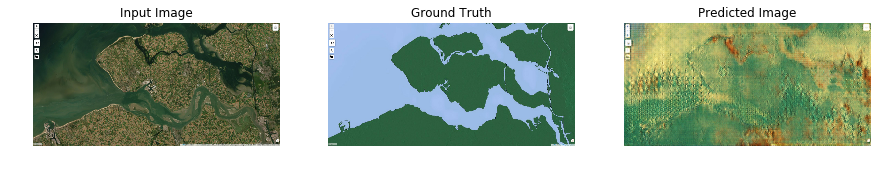

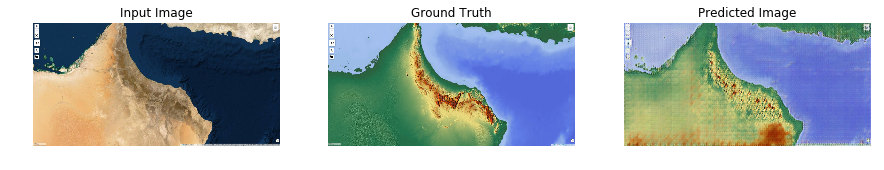

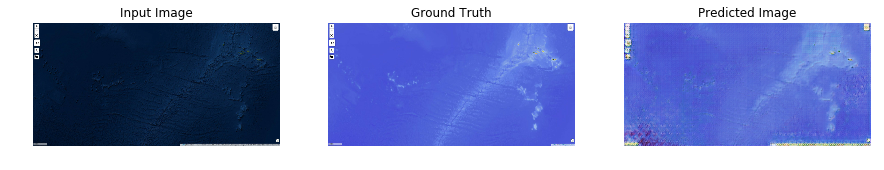

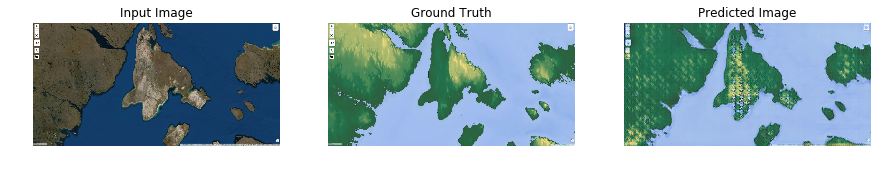

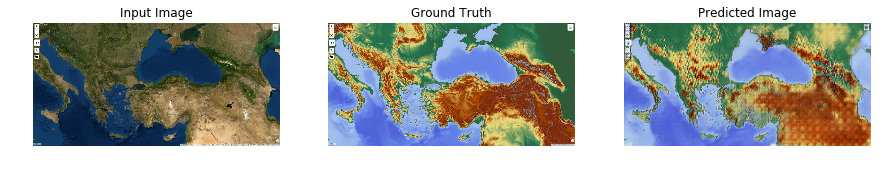

In [0]:
train(train_dataset, 500)